In [10]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 123.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 128.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 142.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 155.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.8/405.8 kB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:


# Then we can keep the original imports
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import os
from skimage.measure import label
import tifffile as tiff

import matplotlib.pyplot as plt
import random

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from scipy.ndimage import binary_fill_holes

2025-06-02 05:06:32.602820: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-02 05:06:32.606426: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 05:06:32.610412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-02 05:06:32.621929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748855192.642088     107 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748855192.64

In [16]:
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [19]:
!ls -l ./monuseg_test

total 40645
-rw-r-----. 1 root users 41620178 May 26 03:40 'MoNuSegTestData (2).zip'


In [22]:
import zipfile

# Path to your zip file in the Google Drive integration
file_path = './monuseg_test/MoNuSegTestData (2).zip'

try:
    # First, we need to extract the contents of the zip file
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        # List the contents of the zip file
        print("Contents of zip file:")
        print(zip_ref.namelist())
        
        # Extract all contents to a directory
        zip_ref.extractall('/tmp/monuseg_extracted')
        
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found. Please check if the file exists and the path is correct.")
except zipfile.BadZipFile:
    print(f"Error: {file_path} is not a valid zip file.")

Contents of zip file:
['MoNuSegTestData/', 'MoNuSegTestData/TCGA-2Z-A9J9-01A-01-TS1.tif', 'MoNuSegTestData/TCGA-2Z-A9J9-01A-01-TS1.xml', 'MoNuSegTestData/TCGA-44-2665-01B-06-BS6.tif', 'MoNuSegTestData/TCGA-44-2665-01B-06-BS6.xml', 'MoNuSegTestData/TCGA-69-7764-01A-01-TS1.tif', 'MoNuSegTestData/TCGA-69-7764-01A-01-TS1.xml', 'MoNuSegTestData/TCGA-A6-6782-01A-01-BS1.tif', 'MoNuSegTestData/TCGA-A6-6782-01A-01-BS1.xml', 'MoNuSegTestData/TCGA-AC-A2FO-01A-01-TS1.tif', 'MoNuSegTestData/TCGA-AC-A2FO-01A-01-TS1.xml', 'MoNuSegTestData/TCGA-AO-A0J2-01A-01-BSA.tif', 'MoNuSegTestData/TCGA-AO-A0J2-01A-01-BSA.xml', 'MoNuSegTestData/TCGA-CU-A0YN-01A-02-BSB.tif', 'MoNuSegTestData/TCGA-CU-A0YN-01A-02-BSB.xml', 'MoNuSegTestData/TCGA-EJ-A46H-01A-03-TSC.tif', 'MoNuSegTestData/TCGA-EJ-A46H-01A-03-TSC.xml', 'MoNuSegTestData/TCGA-FG-A4MU-01B-01-TS1.tif', 'MoNuSegTestData/TCGA-FG-A4MU-01B-01-TS1.xml', 'MoNuSegTestData/TCGA-GL-6846-01A-01-BS1.tif', 'MoNuSegTestData/TCGA-GL-6846-01A-01-BS1.xml', 'MoNuSegTestData/

In [25]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 40.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:2 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [2612 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal/main amd64 Packages [34.8 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [33.1 kB]
Get:10 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [4801 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [4919 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [4998 kB

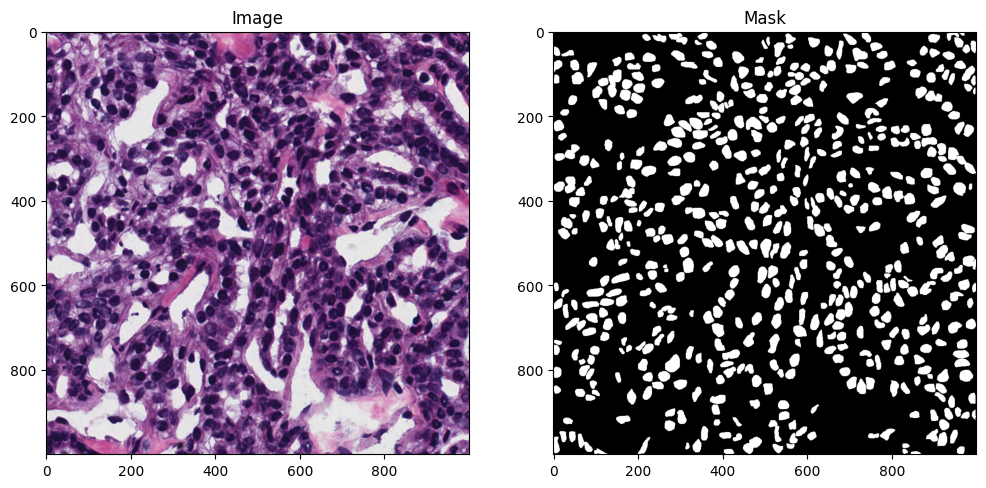

In [28]:
# First, let's install the required OpenGL library
!apt-get update && apt-get install -y libgl1-mesa-glx

# Now we can run the original code
import numpy as np
from pathlib import Path
import tifffile
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import cv2
import matplotlib.pyplot as plt

def xml_to_mask(xml_path, image_shape):
    # Parse XML file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Create empty mask
    mask = Image.new('L', (image_shape[1], image_shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    
    # Extract and draw all nuclei polygons
    for region in root.findall('.//Region'):
        vertices = region.find('Vertices')
        points = []
        for vertex in vertices.findall('Vertex'):
            x = float(vertex.get('X'))
            y = float(vertex.get('Y'))
            points.append((x, y))
        draw.polygon(points, fill=255)
    
    return np.array(mask)

# Get paths for all images and masks
base_path = Path('/tmp/monuseg_extracted/MoNuSegTestData')  # Updated path to match extraction location
image_paths = sorted(base_path.glob('*.tif'))
mask_paths = sorted(base_path.glob('*.xml'))

# Create X and Y arrays
X = []
Y = []

for img_path, xml_path in zip(image_paths, mask_paths):
    # Read image
    img = tifffile.imread(str(img_path))
    
    # Create mask from XML
    mask = xml_to_mask(xml_path, img.shape)
    
    # Append to lists
    X.append(img)
    Y.append(mask)

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)
masks_true = Y

print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")

# Optional: Display first image and mask
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X[0])
plt.title('Image')
plt.subplot(122)
plt.imshow(Y[0], cmap='gray')
plt.title('Mask')
plt.show()

In [31]:
import numpy as np
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from tqdm import tqdm
import matplotlib.pyplot as plt

# Step 1: Normalize H&E RGB images
X_norm = []
for x in tqdm(X, desc="Normalizing H&E RGB images"):
    x_norm = normalize(x, 1, 99.8, axis=(0,1))  # Normalize across spatial axes only
    X_norm.append(x_norm)

# Step 2: Load pre-trained StarDist model
model = StarDist2D.from_pretrained("2D_versatile_he")

# Step 3: Predict masks
Y_pred = []
valid_indices = []

for i in tqdm(range(len(X_norm)), desc="Evaluating StarDist"):
    sample_img = X_norm[i]

    try:
        pred_mask, _ = model.predict_instances(
            sample_img,
            n_tiles=model._guess_n_tiles(sample_img),
            show_tile_progress=False
        )
        Y_pred.append(pred_mask)
        valid_indices.append(i)
    except Exception as e:
        print(f"Error processing image {i}: {e}")


Normalizing H&E RGB images: 100%|██████████| 14/14 [00:00<00:00, 15.11it/s]Found model '2D_versatile_he' for 'StarDist2D'.

5294730/5294730 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
E0000 00:00:1748855300.676091     107 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1748855300.822610     107 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
Evaluating StarDist: 100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


In [34]:
def get_object_count(mask):
    return len(np.unique(mask)) - 1  # exclude background label 0

def get_total_area(mask):
    return np.sum(mask > 0)


# Calculate counts and areas
Stardist_counts = [get_object_count(m) for m in Y_pred]
Stardist_areas = [get_total_area(m) for m in Y_pred]

# Some summary statistics
print(f"Average predicted objects per image: {np.mean(Stardist_counts):.2f}")
print(f"Average predicted area per image: {np.mean(Stardist_areas):.2f}")

Average predicted objects per image: 450.00
Average predicted area per image: 193728.36


In [37]:
import pandas as pd

# Create the DataFrame
df_cellpose = pd.DataFrame({
    'image_index': list(range(len(Y_pred))),
    'object_count': Stardist_counts,
    'total_area': Stardist_areas
})

# Display the DataFrame
print(df_cellpose.head())
# Save the DataFrame to a CSV file in the /work directory
df_cellpose.to_csv('/work/StarDist_sege_area.csv', index=False)

   image_index  object_count  total_area
0            0           571      232066
1            1           743      257466
2            2           445      183851
3            3           359      136299
4            4           449      192140


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12328767..1.0622222].


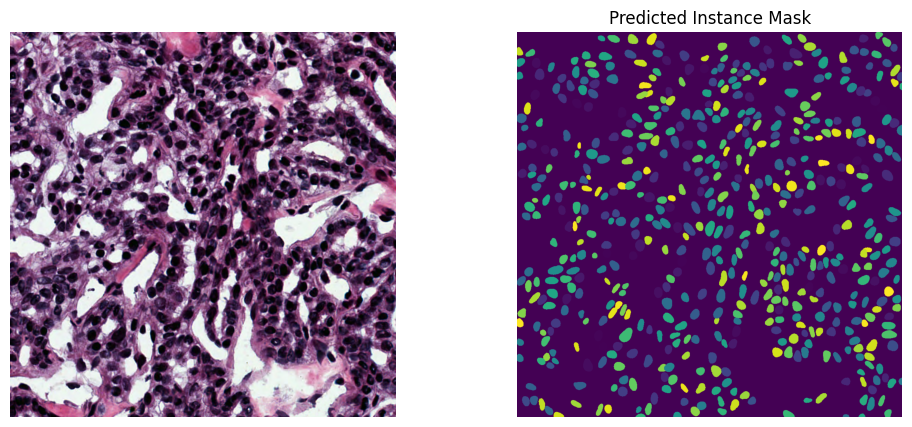

In [28]:
i = valid_indices[0]
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_norm[i])
plt.title("")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(Y_pred[0])
plt.title("Predicted Instance Mask")
plt.axis("off")
plt.show()


In [31]:
from stardist.matching import matching_dataset
from tqdm import tqdm

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats_per_tau = {}

# Convert GT to instance masks
Y_labeled = [label((m == 255).astype(np.uint16)) for m in Y]

for t in tqdm(taus, desc="Computing matching stats"):
    stats = matching_dataset(
        y_true=Y_labeled,
        y_pred=Y_pred ,  
        thresh=t,
        show_progress=False
    )
    print(f"Tau={t:.2f}: {stats}")
    stats_per_tau[t] = stats


Computing matching stats: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]Tau=0.90: DatasetMatching(criterion='iou', thresh=0.9, fp=6183, tp=117, fn=5886, precision=0.018571428571428572, recall=0.019490254872563718, accuracy=0.009601181683899557, f1=0.019019751280175568, n_true=6003, n_pred=6300, mean_true_score=0.017809134988849926, mean_matched_score=0.9137456182740692, panoptic_quality=0.017379214392923042, by_image=False)



In [40]:
import pandas as pd

# Convert to DataFrame
records = []
for t, stats in stats_per_tau.items():
    try:
        record = {"tau": t}
        record.update(stats._asdict())  # works if stats is a namedtuple
        records.append(record)
    except AttributeError:
        print(f"Could not convert stats for tau={t}: type={type(stats)}")

df_stats = pd.DataFrame(records)

# Save as CSV
df_stats.to_csv("stardistHE_tau_results.csv", index=False)

# Optional preview
print(df_stats.head())

   tau criterion  thresh    fp    tp    fn  precision    recall  accuracy  \
0  0.1       iou     0.1   891  5409   594   0.858571  0.901049  0.784595   
1  0.2       iou     0.2   905  5395   608   0.856349  0.898717  0.780979   
2  0.3       iou     0.3   957  5343   660   0.848095  0.890055  0.767672   
3  0.4       iou     0.4  1087  5213   790   0.827460  0.868399  0.735261   
4  0.5       iou     0.5  1363  4937  1066   0.783651  0.822422  0.670242   

         f1  n_true  n_pred  mean_true_score  mean_matched_score  \
0  0.879298    6003    6300         0.659518            0.731945   
1  0.877022    6003    6300         0.659146            0.733429   
2  0.868569    6003    6300         0.656922            0.738069   
3  0.847436    6003    6300         0.649172            0.747550   
4  0.802568    6003    6300         0.628438            0.764131   

   panoptic_quality  by_image  
0          0.643597     False  
1          0.643234     False  
2          0.641064     False  
